In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(3*9755)
tf.random.set_seed(3*9755)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

In [ ]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [ ]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [ ]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    self.gamma = tf.Variable(1, dtype=tf.float32)
    self.beta = tf.Variable(0, dtype=tf.float32)

    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.gamma, self.beta]
  
 def forward(self, X, X_test, function):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, X_test,function)
    else:
      self.y = self.compute_output(X, X_test, function)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, X_test, y_train, opti, function):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, X_test, function)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

 def BN_train(self, X, gamma, beta, eps):

    mean = np.mean(X)
    var = np.mean(((X - mean) ** 2))

    X_hat = (X - mean) / np.sqrt(var + eps)
    BN_Out = gamma * X_hat + beta

    return BN_Out

 def BN_test(self, X, X_test, gamma, beta, eps):

    mean = np.mean(X_test)
    var = np.mean(((X_test - mean) ** 2))

    X_hat = (X - mean) / np.sqrt(var + eps)
    BN_Out = gamma * X_hat + beta

    return BN_Out
           
 def compute_output(self, X, Xtest, function):
    """
    Custom method to obtain output tensor during forward pass
    """
    eps=1e-12
    gamma=self.variables[-2]
    beta=self.variables[-1]

    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    X_test_tf = tf.cast(X_test, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    if function == 'train':
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      z1 = self.BN_train(z1, gamma, beta, eps)
      h1 = tf.nn.relu(z1)

      z2 = tf.matmul(h1, self.W2) + self.b2
      z2 = self.BN_train(z2, gamma, beta, eps)
      h2 = tf.nn.relu(z2)

      z3 = tf.matmul(h2, self.W3) + self.b3
      z3 = self.BN_train(z3, gamma, beta, eps)
      h3 = tf.nn.relu(z3)
    elif function  == 'test':
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      z1_test = tf.matmul(X_test_tf, self.W1) + self.b1
      h1_test = tf.nn.relu(z1_test)

      z1 = self.BN_test(z1, z1_test, gamma, beta, eps)
      h1 = tf.nn.relu(z1)

      z2 = tf.matmul(h1, self.W2) + self.b2
      z2_test = tf.matmul(h1_test, self.W2) + self.b2
      h2_test = tf.nn.relu(z2_test)
      
      z2 = self.BN_test(z2, z2_test, gamma, beta, eps)
      h2 = tf.nn.relu(z2)

      z3 = tf.matmul(h2, self.W3) + self.b3
      z3_test = tf.matmul(h2_test, self.W3) + self.b3
      h3_test = tf.nn.relu(z3_test)
      
      z3 = self.BN_test(z3, z3_test, gamma, beta, eps)
      h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    return output;



Train Accuracy: 0.8424
Number of Epoch = 1 - Average Cross Entropy:= 0.004904132690429688 

Validation Accuracy: 0.8317

Train Accuracy: 0.8467
Number of Epoch = 2 - Average Cross Entropy:= 0.0033044778442382814 

Validation Accuracy: 0.8326

Train Accuracy: 0.8759
Number of Epoch = 3 - Average Cross Entropy:= 0.0029632772827148436 

Validation Accuracy: 0.8595

Train Accuracy: 0.8732
Number of Epoch = 4 - Average Cross Entropy:= 0.002707757568359375 

Total time taken (in seconds): 152.97


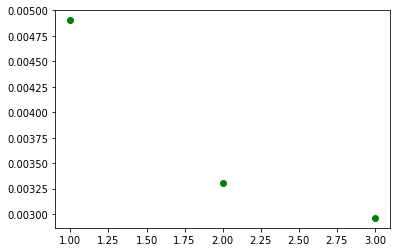

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
va = 0
time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(3*9755)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,X_train, 'train') 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, X_train, outputs, opti, 'train')

  preds = mlp_on_cpu.forward(X_train, X_train, 'train')
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
  preds_val = mlp_on_cpu.forward(X_val, X_val, 'train')
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()
  if va > cur_val_acc:
    break
  va = cur_val_acc
  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs



In [ ]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)

# Test model
preds_test = mlp_on_cpu.forward(X_test, X_test, 'train')
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))


Test Accuracy: 0.85
